# Information Retrieval and Web Analytics



## PROJECT PART 1

Group Members:

*   Berta Alòs (228709)
*   Maria Cerezo (183213)
*   Paula Vilà (231630)












Load packages

In [1]:
from collections import defaultdict
from array import array
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
import json 
from numpy import linalg as la
import pandas as pd 
import re
from operator import itemgetter
import unicodedata
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data preparation and Text processing
The dataset is stored in the JSON file. It contains 4000 Hurricane Ian tweets. 

In [2]:
#reading json file and transforming it into pandas dataframe
tw_data = pd.read_json('tw_hurricane_data.json',lines=True)

#reading the csv file and transforming it into pandas dataframe
map_data = pd.read_csv('tweet_document_ids_map.csv',
                    sep='::', 
                    encoding='latin-1',
                    engine='python',
                    names=['docs_ids'])

tw_data = pd.DataFrame(tw_data)

In [3]:
#creating a new dataframe with the desired columns extracted from tw_data dataframe 
tw_fields = pd.DataFrame()
tw_fields['hashtags']=None
tw_fields['name']=None
tw_fields['full_text']=None
tw_fields['created_at']=None
tw_fields['favorite_count']=None
tw_fields['retweet_count']=None
tw_fields['url']=None

#creating a column with hashtag information obtained from entities column
tw_fields['hashtags'] = tw_data['entities'].apply(lambda x: x.get('hashtags'))

#creating a column with username information obtained from user column
tw_fields['name'] = tw_data['user'].apply(lambda x: x.get('name'))

#creating a column with url information obtained from entities column
for i in tw_data.index:
  tw_fields['url'][i]=tw_data['entities'][i]['media'][0]['url'] if(tw_data['entities'][i].get('media') is not None) else {}

#creating a column with the full_text information of the tw_data dataframe
tw_fields['full_text']=tw_data['full_text']

#creating a column with the created_at information of the tw_data dataframe
tw_fields['created_at']=tw_data['created_at']

#creating a column with the favorite_count information of the tw_data dataframe
tw_fields['favorite_count']=tw_data['favorite_count']

#creating a column with the retweet_count information of the tw_data dataframe
tw_fields['retweet_count']=tw_data['retweet_count']

In [4]:
#creating a new dataset containing the required columns, with it's specified column names
tw_fields = pd.DataFrame({'Tweet' : tw_fields['full_text'],'Username' : tw_fields['name'],  'Date' : tw_fields['created_at'],'Hashtags' : tw_fields['hashtags'], 'Likes' : tw_fields['favorite_count'], 'Retweets' : tw_fields['retweet_count'], 'Url' : tw_fields['url']})

In [5]:
#Function to preprocess data
def build_terms(line):
    """
    Preprocess the text removing stop words, stemming, transforming in 
    lowercase, removing URLs and emojis, removing everything it is not a digit 
    nor number and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    line=re.sub(r'[\W_]+', ' ', line) #BONUS: Removing anything is not a letter or digit
    line = line.lower() 
    line = line.split()  # Tokenize the text to get a list of terms
    line = [x for x in line if x not in stop_words]  # eliminate the stopwords
    line = [stemmer.stem(word) for word in line] # perform stemming (HINT: use List Comprehension)
    line = [l for l in line if "http" not in l ] #BONUS: Removing the URLs from the line
    line = [emojis_out(l) for l in line ] ##BONUS: removing the emojis from the line
    return line

In [6]:
#Function to get rid of emojis
def emojis_out (s):
    """Preprocess the text removing stop emojis from of the string
    
    Arguments:
    s -- string (word) to be processed
    
    Returns: 
    word-- string equal to "" if it's  an emoji and "s" otherwise. 
    """
    emoji_pattern = re.compile("["  
        u"\U0001F300-\U0001F5FF"  # removing symbols & pictographs  
                           "]+", flags=re.UNICODE)
       
    word = emoji_pattern.sub(r'', s)
    return word

In [ ]:
#preprocessing the Tweet and Username information
tw_fields['preprocessed_tweet']=None
for i in tw_fields.index: 
    tw_fields['preprocessed_tweet'][i] = build_terms(tw_fields['Tweet'][i]) 
    tw_fields['Username'][i]=emojis_out(tw_fields['Username'][i])

In [8]:
#merging the tw_fields & map_data dataframes into a single dataframe named final_dataset
final_dataset=pd.merge(map_data, tw_fields, left_index=True, right_index=True)  
final_dataset['doc_id']=None
final_dataset['doc_num']=None
s = final_dataset["docs_ids"].str.split(pat = '\t',expand = True)
final_dataset['doc_id']=s[0]
final_dataset['doc_num']=s[1]
final_dataset.head(3) #displaying the first 3 rows

,docs_ids,Tweet,Username,Date,Hashtags,Likes,Retweets,Url,preprocessed_tweet,doc_id,doc_num
0,doc_1\t1575918182698979328,So this will keep spinning over us until 7 pm…...,Suz,2022-09-30 18:39:08+00:00,"[{'text': 'HurricaneIan', 'indices': [63, 76]}]",0,0,https://t.co/VROTxNS9rz,"[keep, spin, us, 7, pm, go, away, alreadi, hur...",doc_1,1575918182698979328
1,doc_2\t1575918151862304768,Our hearts go out to all those affected by #Hu...,Lytx,2022-09-30 18:39:01+00:00,"[{'text': 'HurricaneIan', 'indices': [43, 56]}]",0,0,{},"[heart, go, affect, hurricaneian, wish, everyo...",doc_2,1575918151862304768
2,doc_3\t1575918140839673873,Kissimmee neighborhood off of Michigan Ave. \n...,Christopher Heath,2022-09-30 18:38:58+00:00,"[{'text': 'HurricaneIan', 'indices': [45, 58]}]",0,0,https://t.co/jf7zseg0Fe,"[kissimme, neighborhood, michigan, ave, hurric...",doc_3,1575918140839673873


##PROJECT PART 2: Indexing and Evaluation

###Indexing

**Inverted Index tfidf function**

In [9]:
def create_index_tfidf(dataset, num_documents):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    lines -- collection of Wikipedia articles
    num_documents -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """
    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    idf = defaultdict(float)
    title_index = defaultdict(str)

    for pos, line in enumerate(dataset['preprocessed_tweet']):  # Remember, lines contain all documents from file
 
        page_id = dataset['doc_id'][pos]
        title_index[page_id] = dataset['Tweet'][pos] #each of the tweets (full text before being preprocessed) 
        current_page_index = {}

        for position, term in enumerate(line):  ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [page_id, array('I', [position])]  #'I' indicates unsigned int (int in Python)

        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] = df[term]+1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)

    return index, tf, df, idf,title_index


index, tf, df, idf, title_index = create_index_tfidf(final_dataset, len(final_dataset))

**Rank documents function**

In [10]:
def rank_documents(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents/tweets, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents and documents scores
    """

    # We are interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # We call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # computing the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculating the score of each doc 
    # Computing the cosine similarity between queyVector and each docVector:

    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_scores = [x[0] for x in doc_scores]
    if len(doc_scores) == 0:
        print("No results found, try again")
        #query1=input()
        #docs = search_tf_idf(query,index)
    return result_docs, result_scores

**Search tf idf function**

In [11]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs = [posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs,ranked_scores = rank_documents(query, docs, index, idf, tf)
    return ranked_docs, ranked_scores

In [12]:
#Looking to the most repeated terms
term=[]
dfterm =[]

#each item of the df is composed by two components: the first one being the term and the second one its df
#iterating through df to get the most repeated terms
item = df.items()

for i in item:
  term.append(i[0])
  dfterm.append(i[1])

doc_freq = pd.DataFrame()
doc_freq['term']=term
doc_freq['df']=dfterm
doc_freq = doc_freq.sort_values(by='df',ascending=False)
doc_freq.head(20)

,term,df
8,hurricaneian,4000
9,co,3042
88,florida,887
56,hurrican,813
86,ian,799
257,help,387
155,amp,362
31,storm,357
105,carolina,304
362,flood,291


####QUERIES

We have decided to generate the queries by combining the most repeated words displayed above.

In [13]:
#QUERY 1:
print("hurricane ian :\n")
query1 = input()
ranked_docs1,ranked_scores1 = search_tf_idf(query1, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs1)))
i=0
for d_id in ranked_docs1[:top]:
    print("page_id= {} - doc_score: {} - original_tweet: {}\n".format(d_id, ranked_scores1[i] ,title_index[d_id]))
    i = i+1

hurricane ian :

hurricane ian

Top 10 results out of 1095 for the searched query:

page_id= doc_634 - doc_score: 1.9399946808643298 - original_tweet: Hurricane IAN #Ian #HurricaneIan #HurricanIan #Huracan #HuracanIan #Hurricane https://t.co/HbllO4Q3vB

page_id= doc_495 - doc_score: 1.9303480851923807 - original_tweet: Hurricane Ian be like 

“You all haven’t had any hurricanes around here lately so I’m just gonna take my time on the East Coast.”

#HurricaneIan #Ian #Hurricane

page_id= doc_1025 - doc_score: 1.8953512111269468 - original_tweet: @colbertlateshow @DirectRelief @ConvoyofHope @WCKitchen @GlobalGiving @StephenAtHome #hope7cc How to help people with the aftermath of Hurricane Ian. #ian #HurricaneIan #Hurricane_Ian #hurricane #charity #PeopleHelpingPeople https://t.co/AKcI4PlhEY

page_id= doc_2140 - doc_score: 1.814775192576548 - original_tweet: #hurricaneian
The perpetual hurricane Ian

page_id= doc_1217 - doc_score: 1.814775192576548 - original_tweet: Hurricane Ian on tour😭

In [14]:
#QUERY 2:
print("south carolina:\n")
query2 = input()
ranked_docs2,ranked_scores2 = search_tf_idf(query2, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs2)))
i=0
for d_id in ranked_docs2[:top]:
    print("page_id= {} - doc_score: {} - original_tweet: {}\n".format(d_id, ranked_scores1[i] ,title_index[d_id]))
    i = i+1

south carolina:

hurricane ian

Top 10 results out of 1095 for the searched query:

page_id= doc_634 - doc_score: 1.9399946808643298 - original_tweet: Hurricane IAN #Ian #HurricaneIan #HurricanIan #Huracan #HuracanIan #Hurricane https://t.co/HbllO4Q3vB

page_id= doc_495 - doc_score: 1.9303480851923807 - original_tweet: Hurricane Ian be like 

“You all haven’t had any hurricanes around here lately so I’m just gonna take my time on the East Coast.”

#HurricaneIan #Ian #Hurricane

page_id= doc_1025 - doc_score: 1.8953512111269468 - original_tweet: @colbertlateshow @DirectRelief @ConvoyofHope @WCKitchen @GlobalGiving @StephenAtHome #hope7cc How to help people with the aftermath of Hurricane Ian. #ian #HurricaneIan #Hurricane_Ian #hurricane #charity #PeopleHelpingPeople https://t.co/AKcI4PlhEY

page_id= doc_2140 - doc_score: 1.814775192576548 - original_tweet: #hurricaneian
The perpetual hurricane Ian

page_id= doc_1217 - doc_score: 1.814775192576548 - original_tweet: Hurricane Ian on tour😭

In [15]:
#QUERY 3:
print("help people :\n")
query3 = input()
ranked_docs3,ranked_scores3= search_tf_idf(query3, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs3)))
i=0
for d_id in ranked_docs3[:top]:
    print("page_id= {} - doc_score: {} - original_tweet: {}\n".format(d_id, ranked_scores1[i] ,title_index[d_id]))
    i = i+1

help people :

help people

Top 10 results out of 556 for the searched query:

page_id= doc_3682 - doc_score: 1.9399946808643298 - original_tweet: Good morning lovelies. Yesterday my employer sent an email about donations to help Florida #HurricaneIan victims. But I wanna hear from YOU, how can people help? The theme parks will be ok, I’m concerned about the PEOPLE! What can people do to help? https://t.co/ERiJukIPVN

page_id= doc_3454 - doc_score: 1.9303480851923807 - original_tweet: Never thought I'd see the day where people say a state should receive no aid funding because of a letter next to a governor's name. Disgusting that people would rather make this tragedy political than see people get help. Some people have truly lost it.
#HurricaneIan #Florida

page_id= doc_812 - doc_score: 1.8953512111269468 - original_tweet: Looking for organizations that are providing help to #HurricaneIan victims in Central Florida. We're trying to connect groups with people who need help. Know of any 

In [16]:
#QUERY 4:
print("flood damage :\n")
query4 = input()
ranked_docs4,ranked_scores4= search_tf_idf(query4, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs4)))
i=0
for d_id in ranked_docs4[:top]:
    print("page_id= {} - doc_score: {} - original_tweet: {}\n".format(d_id, ranked_scores1[i] ,title_index[d_id]))
    i = i+1

flood damage :

flood damage

Top 10 results out of 495 for the searched query:

page_id= doc_3288 - doc_score: 1.9399946808643298 - original_tweet: We're still without power &amp; no estimate for restoration so we went to a hotel. There is minor damage to our roof &amp; some flood damage but nothing major. Everything in our fridge &amp; freezer is gone. But it could've been much worse!! #HurricaneIan

page_id= doc_3909 - doc_score: 1.9303480851923807 - original_tweet: #Map: Where #Hurricane #Ian Hit #Florida Hardest
Officials are still working to assess extent of #damage caused by #HurricaneIan &amp; its subsequent #floods, as reports emerge of destroyed #homes, damaged #power lines &amp; disrupted #water supplies. #stormsurge 
https://t.co/UFlmjVYDLk

page_id= doc_2687 - doc_score: 1.8953512111269468 - original_tweet: Just over Blind Pass Bridge on #Sanibel #Captiva Rd. Significant damage here. Structures missing and damages. #Ian #HurricaneIan #flwx https://t.co/0a9vCgoVD5

page_id=

In [17]:
#QUERY 5:
print("storm in florida :\n")
query5 = input()
ranked_docs5,ranked_scores5= search_tf_idf(query5, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs5)))
i=0
for d_id in ranked_docs5[:top]:
    print("page_id= {} - doc_score: {} - original_tweet: {}\n".format(d_id, ranked_scores1[i] ,title_index[d_id]))
    i = i+1

storm in florida :

storm in florida

Top 10 results out of 1163 for the searched query:

page_id= doc_3189 - doc_score: 1.9399946808643298 - original_tweet: Storm Surge as #Ian moves towards South Carolina

#SouthCarolina #HurricaneIan #Hurricane #Storm #Climate #Viral #Rain #Tornado #Tropicswx #SCwx 

VC: Palmetto Storm Chasers https://t.co/Vh1YQuwDET

page_id= doc_2226 - doc_score: 1.9303480851923807 - original_tweet: #HurricaneIan is no anomaly. The #ClimateCrisis is making #storms more powerful. These kind of storms will be the #NewNormal

Hurricane Ian is the fifth most powerful storm to ever hit USA. Only four other hurricanes have made landfall with sustained winds of more than 155mph

page_id= doc_1714 - doc_score: 1.8953512111269468 - original_tweet: VDOT completing storm preparations in advance of Tropical Storm Ian's arrival https://t.co/7WU3pFba3s #ian #hurricaneian

page_id= doc_1822 - doc_score: 1.814775192576548 - original_tweet: ✅Be prepared before the ⛈ storm

Get ins

### Evaluation



####Functions

**Precision @ K (P@K)**

In [18]:
def precision_at_k(doc_score, k): #binary relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """


    relevant = sum(doc_score[:k] == 1) #getting number of relevant documents
    
    return float(relevant) / k #calculating precision at k, which is the number of relevant documents retrieved at k

**Recall@K (R@K)**

In [19]:
def recall_at_k(doc_score, k): #binary relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """


    relevant = sum(doc_score[:k] == 1) #getting number of relevant documents
    total_relevant=sum(doc_score == 1)
    return float(relevant) /float(total_relevant)  #calculating precision at k, which is the number of relevant documents retrieved at k

**Average Precision@K-AP@K**

In [20]:
def avg_precision_at_k(doc_score, k): #binary relevance, k for a given query
    
    '''
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    k : number of doc to consider.
    
    Returns
    -------
    average precision @k : float
    '''
    
    gtp =  np.sum(doc_score==1) #total number of gt positives
    relevant = doc_score[:k].tolist()  #delimiting the doc_score to k
    ## if all docs are not relevant
    if gtp==0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    ## if any doc is relevant
    for i in range(len(relevant)): 
        if doc_score[i] == 1: #only add the P@k when the doc is relevant
            n_relevant_at_i += 1 
            prec_at_i += n_relevant_at_i / (i+1) #calculate P@k (#relevant docs at k/k)
    return prec_at_i/gtp #return ap


**F1-Score**

In [21]:
def F_1(doc_score, k):  #binary relevance, k for a given query
    '''
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    k : number of doc to consider.
    
    Returns
    -------
    F_1 score @k : float
    '''
      
    relevant = sum(doc_score[:k] == 1) #get number of relevant documents
    P= float(relevant) / k #precision
    total_relevant=sum(doc_score == 1)
    R= float(relevant) /float(total_relevant)#recall
    return 2*R*P/(R+P) #return F_1

**Mean Average Precision (MAP)**

In [22]:
def map_at_k(search_res, k): #receives all the search results dataframe containing all the queries and the results and relevances
    """
    Parameters
    ----------
    search_res: search results dataset containing:
    k : number of doc to consider.   

    Returns
    -------
    mean average precision @ k : float
    """
    
    avp = []
    for q in search_res["query_id"].unique():  # loop over all query ids
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query (get a slice of the dataframe keeping only the data related to the current query)
        avp.append(avg_precision_at_k(np.array(curr_data["relevance"]), k))  #append average precision for current query

    return np.sum(avp) / len(avp), avp  # return mean average precision

**Mean Reciprocal Rank (MRR)**


In [23]:
def rr_at_k(doc_score, k):  #binary relevance, k for a given query
    '''
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    k : number of doc to consider.
    
    Returns
    -------
    Mean Reciprocal Rank for qurrent query
    '''

    doc_score = doc_score[:k] #delimiting the doc_score to k
    if np.sum(doc_score)==0: # if there are not relevant doument return 0
        return 0
    return 1/(np.argmax(doc_score==1)+1) # return mrr (1 / the position of the first relevant doc)

In [24]:
def mrr (dataset):
  mrr = {}
  for k in [10]: #computing mrr for key 10
      RRs = []
      for q in dataset["query_id"].unique(): # loop over all query ids, get rrs for each query at each
        labels =  np.array(dataset[evaluation['query_id']==q]['relevance'])# get labels for current query
        RRs.append(rr_at_k(labels, k)) # append RR for current query
      mrr[k] = np.round(float(sum(RRs)/len(RRs)),4) # Mean RR at current k
      return mrr

**Normalize Discounted Comulative Gain (NDCG)**

In [25]:
def dcg_at_k(doc_score, ideal, k=10):
    '''
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    ideal: ideal vector values
    k : number of doc to consider.
    
    Returns
    -------
    Discounted Cumulative Gain
    '''
    order = np.argsort(ideal)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k]) # take first k (doc_score is alredy ordered)
    gain = 2**doc_score-1 # Compute gain 
    discounts = np.log2(np.arange(len(doc_score))+2) # Compute denominator
    return np.sum(gain / discounts) #return dcg@k


In [26]:
def ndcg_at_k(doc_score, ideal, k):
    '''
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels)
    ideal: Predicted scores
    k : number of doc to consider.
    
    Returns
    -------
    Normalized Discounted Cumulative Gain
    '''
    dcg_max = dcg_at_k(doc_score, doc_score, k) # Ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, ideal, k)/dcg_max,4)  # return ndcg@k

####Evaluation Component 1: 

For this part we are given a baseline with 3 queries and the ground truth files for each query (using a subset of documents from the dataset)

In [27]:
#reading the csv file and transforming it into pandas dataframe
evaluation = pd.read_csv('evaluation_gt.csv')

In [28]:
#creating a subset of document from the dataset for query 1
q_1 = evaluation.loc[evaluation['query_id'] == 1]
subset_q1 = final_dataset[final_dataset.doc_id.isin(q_1['doc'])] 
subset_q1.reset_index(inplace=True)

In [29]:
#creating a subset of document from the dataset for query 1
q_2 = evaluation.loc[evaluation['query_id'] == 2]
subset_q2 = final_dataset[final_dataset.doc_id.isin(q_2['doc'])] 
subset_q2.reset_index(inplace=True)

In [30]:
#creating a subset of document from the dataset for query 1
q_3 = evaluation.loc[evaluation['query_id'] == 3]
subset_q3 = final_dataset[final_dataset.doc_id.isin(q_3['doc'])] 
subset_q3.reset_index(inplace=True)

In [31]:
#QUERY 1
index1, tf1, df1, idf1, title_index1 = create_index_tfidf(subset_q1, len(subset_q1))
print(" Landfall in South Carolina :\n")
q1 = input()
ranked_docsq1, ranked_scoresq1 = search_tf_idf(q1, index1)
top = 20

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docsq1)))
i=0
for d_id in ranked_docsq1[:top]:
    print("page_id= {} - doc_score: {}\n".format(d_id, ranked_scoresq1[i]))
    i = i+1    

 Landfall in South Carolina :

Landfall in South Carolina

Top 20 results out of 10 for the searched query:

page_id= doc_501 - doc_score: 3.2363071714760263

page_id= doc_82 - doc_score: 2.6933244123045115

page_id= doc_165 - doc_score: 2.5468353584065295

page_id= doc_18 - doc_score: 2.380844955839446

page_id= doc_12 - doc_score: 2.1569792375316528

page_id= doc_45 - doc_score: 1.4197269669182109

page_id= doc_9 - doc_score: 1.3537244798413681

page_id= doc_122 - doc_score: 1.2962529264683351

page_id= doc_100 - doc_score: 1.0299979956073295

page_id= doc_52 - doc_score: 0.7188434136736419



In [32]:
#QUERY 2
index2, tf2, df2, idf2, title_index2 = create_index_tfidf(subset_q2, len(subset_q2))
print("help and recovery during the hurricane disaster:\n")
q2 = input()
ranked_docsq2, ranked_scoresq2 = search_tf_idf(q2, index2)
top = 20

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docsq2)))
i=0
for d_id in ranked_docsq2[:top]:
    print("page_id= {} - doc_score: {}\n".format(d_id, ranked_scoresq2[i]))
    i = i+1    

help and recovery during the hurricane disaster:

help and recovery during the hurricane disaster

Top 20 results out of 12 for the searched query:

page_id= doc_402 - doc_score: 4.060124367924001

page_id= doc_268 - doc_score: 2.373691513544

page_id= doc_504 - doc_score: 1.722652446528

page_id= doc_1233 - doc_score: 1.39615625111

page_id= doc_175 - doc_score: 1.1596083651765

page_id= doc_158 - doc_score: 1.0732943815174998

page_id= doc_303 - doc_score: 0.595143484976

page_id= doc_358 - doc_score: 0.5815059165759999

page_id= doc_453 - doc_score: 0.5566855420879999

page_id= doc_373 - doc_score: 0.5348654326479999

page_id= doc_321 - doc_score: 0.474860131688

page_id= doc_306 - doc_score: 0.44197111134899997



In [33]:
#QUERY 3
index3, tf3, df3, idf3, title_index3 = create_index_tfidf(subset_q3, len(subset_q3))
print("floodings in south carolina:\n")
q3 = input()
ranked_docsq3, ranked_scoresq3 = search_tf_idf(q3, index3)
top = 20

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docsq3)))
i=0
for d_id in ranked_docsq3[:top]:
    print("page_id= {} - doc_score: {}\n".format(d_id, ranked_scoresq3[i]))
    i = i+1  

floodings in south carolina:

floodings in south carolina

Top 20 results out of 9 for the searched query:

page_id= doc_66 - doc_score: 3.0541307591230344

page_id= doc_198 - doc_score: 2.9672202532428464

page_id= doc_65 - doc_score: 2.574790172714755

page_id= doc_30 - doc_score: 2.3566741422154727

page_id= doc_148 - doc_score: 2.087891371672821

page_id= doc_370 - doc_score: 1.916230728686067

page_id= doc_150 - doc_score: 1.238357316109912

page_id= doc_112 - doc_score: 1.0238356036489886

page_id= doc_1195 - doc_score: 0.9615806889422145



In [34]:
#creating a dataframe for QUERY1 containing information about doc_id, score and relevance
relevant_1=[1,1,1,1,1,1,1,1,1,1] #since the documents of the query are the same as the ground truth 
eval1 = {'query_id':[1]*10,'query': q1, 'doc': ranked_docsq1[:10], 'relevance': relevant_1}
df_eval1 = pd.DataFrame(eval1)
#doc = ['doc_12','doc_9','doc_18','doc_45','doc_501','doc_52','doc_82','doc_100', 'doc_122','doc_165', 'doc_125']
#df_eval1['relevance']=None
#for i in df_eval1:
  #if df_eval1['doc'] in doc:
    #df_eval1['relevance'] = 1
  #else: 
     #df_eval1['relevance'] = 0
#df_eval1["is_relevant"] = relevant_1
df_eval1.head(10) 

,query_id,query,doc,relevance
0,1,Landfall in South Carolina,doc_501,1
1,1,Landfall in South Carolina,doc_82,1
2,1,Landfall in South Carolina,doc_165,1
3,1,Landfall in South Carolina,doc_18,1
4,1,Landfall in South Carolina,doc_12,1
5,1,Landfall in South Carolina,doc_45,1
6,1,Landfall in South Carolina,doc_9,1
7,1,Landfall in South Carolina,doc_122,1
8,1,Landfall in South Carolina,doc_100,1
9,1,Landfall in South Carolina,doc_52,1


In [35]:
#creating a dataframe for QUERY2 containing information about doc_id, score and relevance
relevant_2=[1,1,1,1,1,1,1,1,1,1] #since the documents of the query are the same as the ground truth 
eval2 = {'query_id':[2]*10,'query': q2, 'doc': ranked_docsq2[:10], 'relevance': relevant_2}
df_eval2 = pd.DataFrame(eval2)
df_eval2

,query_id,query,doc,relevance
0,2,help and recovery during the hurricane disaster,doc_402,1
1,2,help and recovery during the hurricane disaster,doc_268,1
2,2,help and recovery during the hurricane disaster,doc_504,1
3,2,help and recovery during the hurricane disaster,doc_1233,1
4,2,help and recovery during the hurricane disaster,doc_175,1
5,2,help and recovery during the hurricane disaster,doc_158,1
6,2,help and recovery during the hurricane disaster,doc_303,1
7,2,help and recovery during the hurricane disaster,doc_358,1
8,2,help and recovery during the hurricane disaster,doc_453,1
9,2,help and recovery during the hurricane disaster,doc_373,1


In [36]:
#creating a dataframe for QUERY3 containing information about doc_id, score and relevance
relevant_3=[1,1,1,1,1,1,1,1] #since all the documents are the same as the ground truth 
eval3 = {'query_id':[3]*8,'query': q3, 'doc': ranked_docsq2[:8], 'relevance': relevant_3}
df_eval3 = pd.DataFrame(eval3)
df_eval3

,query_id,query,doc,relevance
0,3,floodings in south carolina,doc_402,1
1,3,floodings in south carolina,doc_268,1
2,3,floodings in south carolina,doc_504,1
3,3,floodings in south carolina,doc_1233,1
4,3,floodings in south carolina,doc_175,1
5,3,floodings in south carolina,doc_158,1
6,3,floodings in south carolina,doc_303,1
7,3,floodings in south carolina,doc_358,1


In [37]:
k=10 #k=10 for query 1 and 2
k3=8 #k=8 for query 3

In [38]:
#Calculating precision at @10 for query 1 and 2 and at @8 for query 3
print("QUERY 1 ==> Precision@{}: {}\n".format(k, precision_at_k(df_eval1["relevance"], k)))
print("QUERY 2 ==> Precision@{}: {}\n".format(k, precision_at_k(df_eval2["relevance"], k)))
print("QUERY 3 ==> Precision@{}: {}\n".format(k3, precision_at_k(df_eval3["relevance"], k3)))

QUERY 1 ==> Precision@10: 1.0

QUERY 2 ==> Precision@10: 1.0

QUERY 3 ==> Precision@8: 1.0



In [39]:
#Calculating recall at @10 for query 1 and 2 and at @8 for query 3

print("QUERY 1 ==> Recall@{}: {}\n".format(k, recall_at_k(df_eval1["relevance"], k)))
print("QUERY 2 ==> Recall@{}: {}\n".format(k, recall_at_k(df_eval2["relevance"], k)))
print("QUERY 3 ==> Recall@{}: {}\n".format(k3, recall_at_k(df_eval3["relevance"], k3)))


QUERY 1 ==> Recall@10: 1.0

QUERY 2 ==> Recall@10: 1.0

QUERY 3 ==> Recall@8: 1.0



In [40]:
#Calculating the average precision at @10 for query 1 and 2 and at @8 for query 3

print("QUERY 1 ==> Average precision@{}: {}\n".format(k, avg_precision_at_k(df_eval1["relevance"], k)))
print("QUERY 2 ==> Average precision@{}: {}\n".format(k, avg_precision_at_k(df_eval2["relevance"], k)))
print("QUERY 3 ==> Average precision@{}: {}\n".format(k3, avg_precision_at_k(df_eval3["relevance"], k3)))

QUERY 1 ==> Average precision@10: 1.0

QUERY 2 ==> Average precision@10: 1.0

QUERY 3 ==> Average precision@8: 1.0



In [41]:
#Calculating the F-1 score at @10 for query 1 and 2 and at @8 for query 3

print("QUERY 1 ==> F-1 score @{}: {}\n".format(k, F_1(df_eval1["relevance"], k)))
print("QUERY 2 ==> F-1 score @{}: {}\n".format(k, F_1(df_eval2["relevance"], k)))
print("QUERY 3 ==> F-1 score @{}: {}\n".format(k3, F_1(df_eval3["relevance"], k3)))


QUERY 1 ==> F-1 score @10: 1.0

QUERY 2 ==> F-1 score @10: 1.0

QUERY 3 ==> F-1 score @8: 1.0



In [42]:
#concatenating all the QUERIES dataframes to be able to calculate the map_k
evaluation123 = pd.concat([df_eval1, df_eval2, df_eval3], axis=0, ignore_index=True)
map_k1, avp1 = map_at_k(evaluation123, 10)
print('MAP value:',map_k1)

MAP value: 1.0


In [43]:
#Calculating the reciprocal rank at @10 for query 1 and 2 and at @8 for query 3
print("QUERY 1 ==> reciprocal rank @{}: {}\n".format(k, rr_at_k(df_eval1["relevance"], k)))
print("QUERY 2 ==> reciprocal rank @{}: {}\n".format(k, rr_at_k(df_eval2["relevance"], k)))
print("QUERY 3 ==> reciprocal rank @{}: {}\n".format(k3, rr_at_k(df_eval3["relevance"], k3)))

QUERY 1 ==> reciprocal rank @10: 1.0

QUERY 2 ==> reciprocal rank @10: 1.0

QUERY 3 ==> reciprocal rank @8: 1.0



In [44]:
#displaying by screen the mrr for key 10 
print('mmr value: ', mrr(evaluation123))

mmr value:  {10: 1.0}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [45]:
#The ideal vector is created by sorting all relevance scores in decreasing order
ideal_1 = np.sort(relevant_1)[::-1]
ideal_2 = np.sort(relevant_2)[::-1]
ideal_3 = np.sort(relevant_3)[::-1]

#Calculating ndcg at k for each of the 3 queries and printing the result
print("QUERY 1 ==> ncdg_at_k{}: {}\n".format(k, ndcg_at_k(df_eval1["relevance"], ideal_1, 10), k))
print("QUERY 1 ==> ncdg_at_k{}: {}\n".format(k, ndcg_at_k(df_eval2["relevance"], ideal_2, 10), k))
print("QUERY 3 ==> ncdg_at_k{}: {}\n".format(k3, ndcg_at_k(df_eval3["relevance"], ideal_3, 8), k3))

QUERY 1 ==> ncdg_at_k10: 1.0

QUERY 1 ==> ncdg_at_k10: 1.0

QUERY 3 ==> ncdg_at_k8: 1.0



####Evaluation Component 2

In [46]:
#creating a dataframe for QUERY1 containing information about doc_id, score and relevance
relevant1=[1,1,0,0,1,0,1,1,0,1]
evaluation1 = {'query_id':[1]*10,'query': query1, 'doc_id': ranked_docs1[:10],'score':ranked_scores1[:10], 'relevance': relevant1}
df_evaluation1 = pd.DataFrame(evaluation1)
df_evaluation1.head(10) 

,query_id,query,doc_id,score,relevance
0,1,hurricane ian,doc_634,1.939995,1
1,1,hurricane ian,doc_495,1.930348,1
2,1,hurricane ian,doc_1025,1.895351,0
3,1,hurricane ian,doc_2140,1.814775,0
4,1,hurricane ian,doc_1217,1.814775,1
5,1,hurricane ian,doc_628,1.654508,0
6,1,hurricane ian,doc_640,1.623135,1
7,1,hurricane ian,doc_1986,1.566086,1
8,1,hurricane ian,doc_1907,1.547640,0
9,1,hurricane ian,doc_807,1.515540,1


In [47]:
#creating a dataframe for QUERY2 containing information about doc_id, score and relevance
relevant2=[0,1,0,0,1,0,1,1,0,1]
evaluation2 = {'query_id':[2]*10,'query': query2, 'doc_id': ranked_docs2[:10],'score':ranked_scores2[:10], 'relevance': relevant2}
df_evaluation2 = pd.DataFrame(evaluation2)
df_evaluation2.head(10) 

,query_id,query,doc_id,score,relevance
0,2,hurricane ian,doc_634,1.939995,0
1,2,hurricane ian,doc_495,1.930348,1
2,2,hurricane ian,doc_1025,1.895351,0
3,2,hurricane ian,doc_2140,1.814775,0
4,2,hurricane ian,doc_1217,1.814775,1
5,2,hurricane ian,doc_628,1.654508,0
6,2,hurricane ian,doc_640,1.623135,1
7,2,hurricane ian,doc_1986,1.566086,1
8,2,hurricane ian,doc_1907,1.547640,0
9,2,hurricane ian,doc_807,1.515540,1


In [48]:
#creating a dataframe for QUERY3 containing information about doc_id, score and relevance
relevant3=[1,1,1,0,1,1,0,0,0,0]
evaluation3 = {'query_id':[3]*10,'query': query3, 'doc_id': ranked_docs3[:10],'score':ranked_scores3[:10], 'relevance': relevant3}
df_evaluation3 = pd.DataFrame(evaluation3)
df_evaluation3.head(10)

,query_id,query,doc_id,score,relevance
0,3,help people,doc_3682,4.729731,1
1,3,help people,doc_3454,4.038435,1
2,3,help people,doc_812,3.914591,1
3,3,help people,doc_3428,3.821923,0
4,3,help people,doc_2027,3.594043,1
5,3,help people,doc_280,3.439559,1
6,3,help people,doc_2753,3.426107,0
7,3,help people,doc_1300,3.261325,0
8,3,help people,doc_191,3.196308,0
9,3,help people,doc_3730,3.110959,0


In [49]:
#creating a dataframe for QUERY4 containing information about doc_id, score and relevance
relevant4=[0,1,1,1,0,1,0,1,1,1]
evaluation4 = {'query_id':[4]*10,'query': query4, 'doc_id': ranked_docs4[:10],'score':ranked_scores4[:10], 'relevance': relevant4}
df_evaluation4 = pd.DataFrame(evaluation4)
df_evaluation4.head(10) 

,query_id,query,doc_id,score,relevance
0,4,flood damage,doc_3288,2.841600,0
1,4,flood damage,doc_3909,2.758933,1
2,4,flood damage,doc_2687,2.702347,1
3,4,flood damage,doc_1493,2.659882,1
4,4,flood damage,doc_585,2.647264,0
5,4,flood damage,doc_2515,2.647264,1
6,4,flood damage,doc_3743,2.610777,0
7,4,flood damage,doc_1862,2.595777,1
8,4,flood damage,doc_2488,2.507875,1
9,4,flood damage,doc_1374,2.507875,1


In [50]:
#creating a dataframe for QUERY5 containing information about doc_id, score and relevance
relevant5=[1,1,1,0,0,0,1,1,1,1]
evaluation5 = {'query_id':[5]*10,'query': query5, 'doc_id': ranked_docs5[:10],'score':ranked_scores5[:10], 'relevance': relevant5}
df_evaluation5 = pd.DataFrame(evaluation5)
df_evaluation5 

,query_id,query,doc_id,score,relevance
0,5,storm in florida,doc_3189,2.299958,1
1,5,storm in florida,doc_2226,2.124086,1
2,5,storm in florida,doc_1714,2.002710,1
3,5,storm in florida,doc_1822,1.946150,0
4,5,storm in florida,doc_3596,1.910681,0
5,5,storm in florida,doc_3475,1.846241,0
6,5,storm in florida,doc_3311,1.846241,1
7,5,storm in florida,doc_2794,1.831200,1
8,5,storm in florida,doc_2323,1.801654,1
9,5,storm in florida,doc_2070,1.800217,1


In [52]:
#Calculating precision at @10 for each of the 5 queries and printing the result
k = 10
print("QUERY 1 ==> Precision@{}: {}\n".format(k, precision_at_k(df_evaluation1["relevance"], k)))
print("QUERY 2 ==> Precision@{}: {}\n".format(k, precision_at_k(df_evaluation2["relevance"], k)))
print("QUERY 3 ==> Precision@{}: {}\n".format(k, precision_at_k(df_evaluation3["relevance"], k)))
print("QUERY 4 ==> Precision@{}: {}\n".format(k, precision_at_k(df_evaluation4["relevance"], k)))
print("QUERY 5 ==> Precision@{}: {}\n".format(k, precision_at_k(df_evaluation5["relevance"], k)))


QUERY 1 ==> Precision@10: 0.6

QUERY 2 ==> Precision@10: 0.5

QUERY 3 ==> Precision@10: 0.5

QUERY 4 ==> Precision@10: 0.7

QUERY 5 ==> Precision@10: 0.7



In [53]:
#Calculating recall at @10 for each of the 5 queries and printing the result
k = 10
print("QUERY 1 ==> Recall@{}: {}\n".format(k, recall_at_k(df_evaluation1["relevance"], k)))
print("QUERY 2 ==> Recall@{}: {}\n".format(k, recall_at_k(df_evaluation2["relevance"], k)))
print("QUERY 3 ==> Recall@{}: {}\n".format(k, recall_at_k(df_evaluation3["relevance"], k)))
print("QUERY 4 ==> Recall@{}: {}\n".format(k, recall_at_k(df_evaluation4["relevance"], k)))
print("QUERY 5 ==> Recall@{}: {}\n".format(k, recall_at_k(df_evaluation5["relevance"], k)))


QUERY 1 ==> Recall@10: 1.0

QUERY 2 ==> Recall@10: 1.0

QUERY 3 ==> Recall@10: 1.0

QUERY 4 ==> Recall@10: 1.0

QUERY 5 ==> Recall@10: 1.0



In [54]:
#Calculating average precision at @10 for each of the 5 queries and printing the result
k = 10
print("QUERY 1 ==> Average precision@{}: {}\n".format(k, avg_precision_at_k(df_evaluation1["relevance"], k)))
print("QUERY 2 ==> Average precision@{}: {}\n".format(k, avg_precision_at_k(df_evaluation2["relevance"], k)))
print("QUERY 3 ==> Average precision@{}: {}\n".format(k, avg_precision_at_k(df_evaluation3["relevance"], k)))
print("QUERY 4 ==> Average precision@{}: {}\n".format(k, avg_precision_at_k(df_evaluation4["relevance"], k)))
print("QUERY 5 ==> Average precision@{}: {}\n".format(k, avg_precision_at_k(df_evaluation5["relevance"], k)))

QUERY 1 ==> Average precision@10: 0.7327380952380952

QUERY 2 ==> Average precision@10: 0.46571428571428564

QUERY 3 ==> Average precision@10: 0.9266666666666665

QUERY 4 ==> Average precision@10: 0.6535714285714285

QUERY 5 ==> Average precision@10: 0.7947278911564626



In [55]:
#Calculating F1 at @10 for each of the 5 queries and printing the result
k = 10
print("QUERY 1 ==> F-1 score@{}: {}\n".format(k, F_1(df_evaluation1["relevance"], k)))
print("QUERY 2 ==> F-1 score@{}: {}\n".format(k, F_1(df_evaluation2["relevance"], k)))
print("QUERY 3 ==> F-1 score@{}: {}\n".format(k, F_1(df_evaluation3["relevance"], k)))
print("QUERY 4 ==> F-1 score@{}: {}\n".format(k, F_1(df_evaluation4["relevance"], k)))
print("QUERY 5 ==> F-1 score@{}: {}\n".format(k, F_1(df_evaluation5["relevance"], k)))


QUERY 1 ==> F-1 score@10: 0.7499999999999999

QUERY 2 ==> F-1 score@10: 0.6666666666666666

QUERY 3 ==> F-1 score@10: 0.6666666666666666

QUERY 4 ==> F-1 score@10: 0.8235294117647058

QUERY 5 ==> F-1 score@10: 0.8235294117647058



In [56]:
#concatenating all the QUERIES dataframes to be able to calculate the map_k
evaluation = pd.concat([df_evaluation1, df_evaluation2, df_evaluation3, df_evaluation4, df_evaluation5], axis=0, ignore_index=True)
map_k, avp = map_at_k(evaluation, 10)
print('MAP value:',map_k)

MAP value: 0.7146836734693875


In [57]:
#Calculating rr_at_k at @10 for each of the 5 queries and printing the result
k = 10
print("QUERY 1 ==> rr_at_k{}: {}\n".format(k, rr_at_k(evaluation[evaluation["query_id"]==1]["relevance"], k)))
print("QUERY 2==> rr_at_k{}: {}\n".format(k, rr_at_k(evaluation[evaluation["query_id"]==2]["relevance"], k)))
print("QUERY 3 ==> rr_at_k{}: {}\n".format(k, rr_at_k(evaluation[evaluation["query_id"]==3]["relevance"], k)))
print("QUERY 4 ==> rr_at_k{}: {}\n".format(k, rr_at_k(evaluation[evaluation["query_id"]==4]["relevance"], k)))
print("QUERY 5 ==> rr_at_k{}: {}\n".format(k, rr_at_k(evaluation[evaluation["query_id"]==5]["relevance"], k)))

QUERY 1 ==> rr_at_k10: 1.0

QUERY 2==> rr_at_k10: 0.5

QUERY 3 ==> rr_at_k10: 1.0

QUERY 4 ==> rr_at_k10: 0.5

QUERY 5 ==> rr_at_k10: 1.0



In [58]:
#displaying by screen the mrr for key 10 
print('mmr value: ', mrr(evaluation))

mmr value:  {10: 0.8}


In [59]:
#The ideal vector is created by sorting all relevance scores in decreasing order
ideal1 = np.sort(relevant1)[::-1]
ideal2 = np.sort(relevant2)[::-1]
ideal3 = np.sort(relevant3)[::-1]
ideal4 = np.sort(relevant4)[::-1]
ideal5 = np.sort(relevant5)[::-1]

#Calculating ndcg at k for each of the 5 queries and printing the result
k = 10
print("QUERY 1 ==> ncdg_at_k{}: {}\n".format(k, ndcg_at_k(df_evaluation1["relevance"], ideal1, 10), k))
print("QUERY 2==> ncdg_at_k{}: {}\n".format(k, ndcg_at_k(df_evaluation2["relevance"], ideal2, 10), k))
print("QUERY 3 ==> ncdg_at_k{}: {}\n".format(k, ndcg_at_k(df_evaluation3["relevance"], ideal3, 10), k))
print("QUERY 4 ==> ncdg_at_k{}: {}\n".format(k, ndcg_at_k(df_evaluation4["relevance"], ideal4, k)))
print("QUERY 5 ==> ncdg_at_k{}: {}\n".format(k, ndcg_at_k(df_evaluation5["relevance"], ideal5, 10), k))


QUERY 1 ==> ncdg_at_k10: 0.6952

QUERY 2==> ncdg_at_k10: 0.8151

QUERY 3 ==> ncdg_at_k10: 0.8841

QUERY 4 ==> ncdg_at_k10: 0.745

QUERY 5 ==> ncdg_at_k10: 0.8197



##### Vector Representation

In [60]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import re
import matplotlib.pyplot as plt


[('storm', 0.9987034797668457), ('co', 0.9982460737228394), ('ian', 0.9976016879081726), ('south', 0.996376633644104), ('make', 0.9955636262893677), ('north', 0.995172381401062), ('beach', 0.9947823882102966), ('florida', 0.9947284460067749), ('carolina', 0.994482159614563), ('southcarolina', 0.9941931962966919)]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


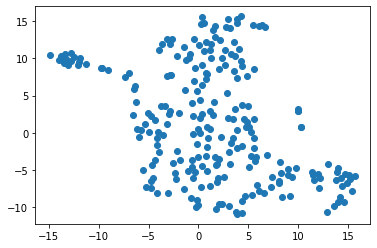

In [64]:
tweets=[]
for i in tw_fields.index: 
    tweets.append(tw_fields['preprocessed_tweet'][i])
tweets

model = Word2Vec(tweets, workers=4, size=100, min_count=50, window=10, sample=1e-3)

print (model.wv.most_similar('hurrican'))

X = model.wv[model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()